In [1]:
import pandas as pd
from acquire import get_world_data
import prepare
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression, LinearRegression


# Acquire

**Showing acquire function using a SQL query**

In [2]:
def new_world_data():
    
    sql_query = 'SELECT country.Name as countryname, Continent as continent, Region as region, SurfaceArea as surfacearea, country.Population as countrypopulation, LifeExpectancy as lifeexpectancy, GNP as gnp, city.name as cityname, city.population as citypopulation FROM country JOIN city on country.code = city.countrycode'
    df = pd.read_sql(sql_query, get_connection('world'))
    df.to_csv('country.csv')
    return df

# Prepare

**Showing prep function used to clean and create new derived columns.** 

In [3]:
def prep_world_data():
    df = get_world_data()
    #dropping null rows, only nulls are target variable and not going to impute mean
    df.dropna(inplace=True)
    #Creating a boolean column whether or not life exp is above or below 77
    df['highest_life_exp'] = df['lifeexpectancy'].apply(lambda x: 1 if x >= 77 else 0)
    #GNP is abbreviated. After doing calculations, I need to multiply gnp by a million to get actual figure. Will use this to determine gnp per capita.
    df['real_gnp'] = df.gnp * 1000000
    #Taking population and gnp to get more data
    df['gnp_per_capita'] = round(df.real_gnp / df.countrypopulation, 2)
    #Creating a column to determine how densly populated each country is to determine if that factors into life expectancy.
    df['country_pop_density'] = df.countrypopulation / df.surfacearea

    
    train_validate, test = train_test_split(df, test_size=.2, random_state=123, 
                                        stratify=df.highest_life_exp)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123, 
                                   stratify=train_validate.highest_life_exp)

    return train, validate, test

In [4]:
train, validate, test = prep_world_data()

In [5]:
train.shape, validate.shape, test.shape

((2277, 14), (977, 14), (814, 14))

In [6]:
train.head()

,code,countryname,continent,region,surfacearea,countrypopulation,lifeexpectancy,gnp,cityname,citypopulation,highest_life_exp,real_gnp,gnp_per_capita,country_pop_density
638,CHN,China,Asia,Eastern Asia,9572900.0,1277558000,71.4,982268.0,Baoji,337765,0,9.822680e+11,768.86,133.455693
868,CHN,China,Asia,Eastern Asia,9572900.0,1277558000,71.4,982268.0,Huangshan,102628,0,9.822680e+11,768.86,133.455693
2132,JPN,Japan,Asia,Eastern Asia,377829.0,126714000,80.7,3787042.0,Kofu,199753,1,3.787042e+12,29886.53,335.373939
264,BRA,Brazil,South America,South America,8547403.0,170115000,62.9,776739.0,Rio Branco,259537,0,7.767390e+11,4565.96,19.902536
2439,MDA,Moldova,Europe,Eastern Europe,33851.0,4380000,64.5,1579.0,Tiraspol,194300,0,1.579000e+09,360.50,129.390565


# Explore

**Going to perform various aggregations and visualizations for exploration purposes**

In [7]:
train.groupby(['continent']).highest_life_exp.mean().sort_values(ascending=False)

continent
North America    0.583587
Europe           0.520971
Oceania          0.423077
Asia             0.151759
South America    0.000000
Africa           0.000000
Name: highest_life_exp, dtype: float64

In [8]:
train.groupby(['continent', 'region']).highest_life_exp.mean().sort_values(ascending=False)

continent      region                   
Oceania        Australia and New Zealand    1.000000
Europe         Western Europe               1.000000
North America  North America                0.989362
Europe         British Islands              0.976744
               Southern Europe              0.863636
               Nordic Countries             0.850000
Asia           Eastern Asia                 0.319540
North America  Caribbean                    0.171429
Asia           Middle East                  0.130952
               Southeast Asia               0.005988
South America  South America                0.000000
Africa         Eastern Africa               0.000000
               Northern Africa              0.000000
               Southern Africa              0.000000
               Western Africa               0.000000
Europe         Eastern Europe               0.000000
Asia           Southern and Central Asia    0.000000
Europe         Baltic Countries             0.000000
Ocean

In [9]:
#Western countries have the highest life expectancy on average. North America as a whole has a slightly lower avg than the region of NA due to Central America. Also for Europe, 
#their average is pulled down by the Baltic and Eastern European countries.

In [10]:
train[(train.citypopulation > 5_000_000) & (train.highest_life_exp == 1)]

,code,countryname,continent,region,surfacearea,countrypopulation,lifeexpectancy,gnp,cityname,citypopulation,highest_life_exp,real_gnp,gnp_per_capita,country_pop_density
3647,USA,United States,North America,North America,9363520.0,278357000,77.1,8510700.0,New York,8008278,1,8.510700e+12,30574.77,29.727816


In [11]:
len(train[(train.citypopulation > 5_000_000)])

14

In [12]:
train[(train.citypopulation > 3_000_000) & (train.highest_life_exp == 1)]

,code,countryname,continent,region,surfacearea,countrypopulation,lifeexpectancy,gnp,cityname,citypopulation,highest_life_exp,real_gnp,gnp_per_capita,country_pop_density
2027,JPN,Japan,Asia,Eastern Asia,377829.0,126714000,80.7,3787042.0,Jokohama [Yokohama],3339594,1,3.787042e+12,29886.53,335.373939
83,AUS,Australia,Oceania,Australia and New Zealand,7741220.0,18886000,79.8,351182.0,Sydney,3276207,1,3.511820e+11,18594.83,2.439667
3647,USA,United States,North America,North America,9363520.0,278357000,77.1,8510700.0,New York,8008278,1,8.510700e+12,30574.77,29.727816
997,DEU,Germany,Europe,Western Europe,357022.0,82164700,77.4,2133367.0,Berlin,3386667,1,2.133367e+12,25964.52,230.139039
3385,SGP,Singapore,Asia,Southeast Asia,618.0,3567000,80.1,86503.0,Singapore,4017733,1,8.650300e+10,24250.91,5771.844660


In [13]:
train[(train.citypopulation > 2_000_000) & (train.highest_life_exp == 1)]

,code,countryname,continent,region,surfacearea,countrypopulation,lifeexpectancy,gnp,cityname,citypopulation,highest_life_exp,real_gnp,gnp_per_capita,country_pop_density
2027,JPN,Japan,Asia,Eastern Asia,377829.0,126714000,80.7,3787042.0,Jokohama [Yokohama],3339594,1,3.787042e+12,29886.53,335.373939
1175,ESP,Spain,Europe,Southern Europe,505992.0,39441700,78.8,553233.0,Madrid,2879052,1,5.532330e+11,14026.60,77.949256
1960,ITA,Italy,Europe,Southern Europe,301316.0,57680000,79.0,1161755.0,Roma,2643581,1,1.161755e+12,20141.38,191.426940
83,AUS,Australia,Oceania,Australia and New Zealand,7741220.0,18886000,79.8,351182.0,Sydney,3276207,1,3.511820e+11,18594.83,2.439667
2029,JPN,Japan,Asia,Eastern Asia,377829.0,126714000,80.7,3787042.0,Nagoya,2154376,1,3.787042e+12,29886.53,335.373939
3647,USA,United States,North America,North America,9363520.0,278357000,77.1,8510700.0,New York,8008278,1,8.510700e+12,30574.77,29.727816
1252,FRA,France,Europe,Western Europe,551500.0,59225700,78.8,1424285.0,Paris,2125246,1,1.424285e+12,24048.43,107.390209
2028,JPN,Japan,Asia,Eastern Asia,377829.0,126714000,80.7,3787042.0,Osaka,2595674,1,3.787042e+12,29886.53,335.373939
997,DEU,Germany,Europe,Western Europe,357022.0,82164700,77.4,2133367.0,Berlin,3386667,1,2.133367e+12,25964.52,230.139039
3385,SGP,Singapore,Asia,Southeast Asia,618.0,3567000,80.1,86503.0,Singapore,4017733,1,8.650300e+10,24250.91,5771.844660


In [14]:
len(train[train.citypopulation > 2_000_000])

57

In [15]:
#Out of 57 cities with a population over 2 million, only 10 was the avg life expectancy 77 or higher.
#Out of 14 cities with a population over 5 million, NYC was the only city with an avg life expectancy 77 or higher.

# Visualizations

Text(0.5, 0, 'Highest Life Expectancy')

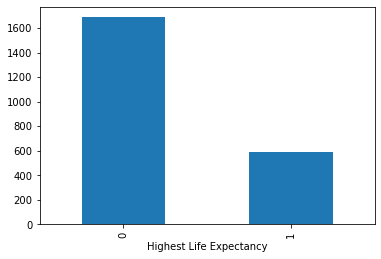

In [16]:
#Visualize the target variable
train.highest_life_exp.value_counts().plot.bar()
plt.xlabel('Highest Life Expectancy')

**Going to look at the relationship between the target variable and a few other key features**

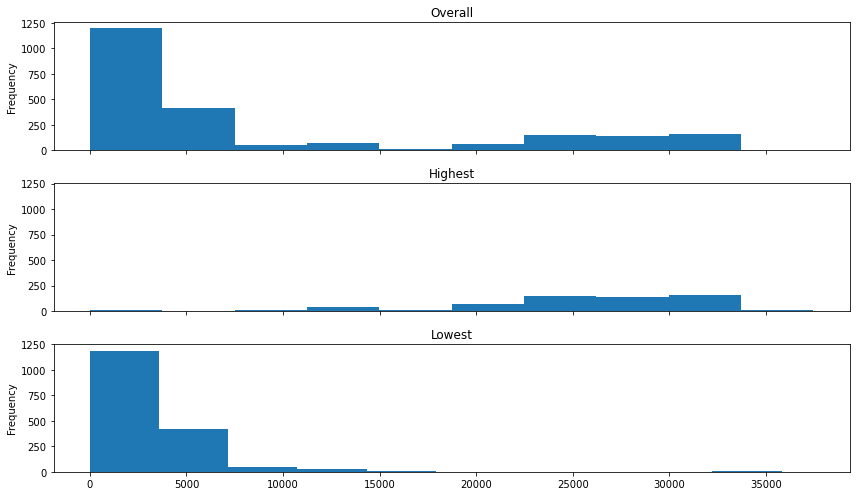

In [17]:
fig, axs = plt.subplots(3, 1, figsize=(12, 7), sharex=True, sharey=True)

train.gnp_per_capita.plot.hist(ax=axs[0], title='Overall')
train[train.highest_life_exp == 1].gnp_per_capita.plot.hist(ax=axs[1], title='Highest')
train[train.highest_life_exp == 0].gnp_per_capita.plot.hist(ax=axs[2], title='Lowest')
fig.tight_layout()


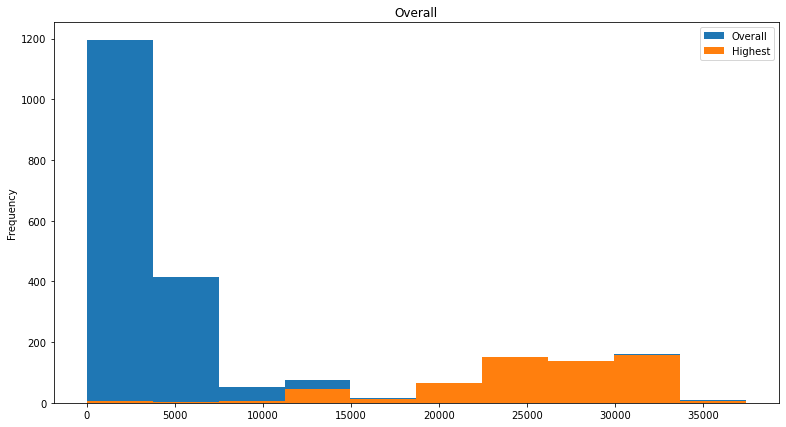

In [18]:
ax = train.gnp_per_capita.plot.hist(title='Overall', figsize=(13, 7), label='Overall')
train[train.highest_life_exp == 1].gnp_per_capita.plot.hist(ax=ax, label='Highest')
plt.legend()

In [19]:
#Most of the locations with the highest life expectancy also have a higher GNP per capita.

<AxesSubplot:>

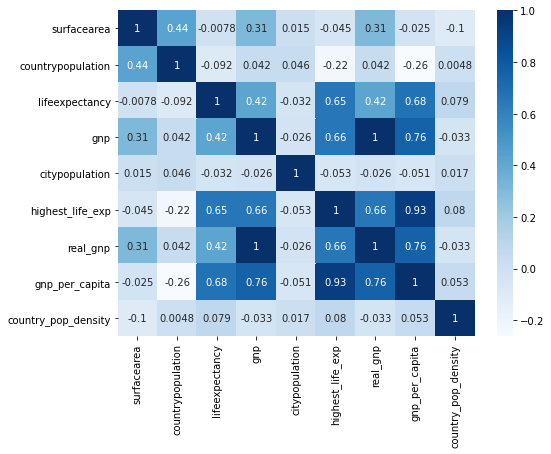

In [20]:
plt.figure(figsize=(8,6))
sns.heatmap(train.corr(), cmap='Blues', annot=True)

# Hypothesis Testing

In [21]:
alpha = .05

In [22]:
x = train.gnp_per_capita
y = train.lifeexpectancy

In [23]:
r, p = stats.pearsonr(x, y)
print('r =', r)
print('p =', p)
p < alpha

r = 0.6751177202301126
p = 6.81888122998852e-303


True

In [24]:
#There is a significant relationship between gnp_per_capita and lifeexpectancy

# Modeling

**Set Baseline**

In [25]:
train.highest_life_exp.value_counts(normalize=True)


0    0.740887
1    0.259113
Name: highest_life_exp, dtype: float64

In [26]:
#Baseline is 74% accuracy

In [27]:
test.head()

,code,countryname,continent,region,surfacearea,countrypopulation,lifeexpectancy,gnp,cityname,citypopulation,highest_life_exp,real_gnp,gnp_per_capita,country_pop_density
18,ARE,United Arab Emirates,Asia,Middle East,83600.0,2441000,74.1,37966.0,al-Ayn,225970,0,3.796600e+10,15553.46,29.198565
1012,DEU,Germany,Europe,Western Europe,357022.0,82164700,77.4,2133367.0,Bochum,392830,1,2.133367e+12,25964.52,230.139039
2484,MEX,Mexico,North America,Central America,1958201.0,98881000,71.5,414972.0,Tultitlán,432411,0,4.149720e+11,4196.68,50.495838
1221,ESP,Spain,Europe,Southern Europe,505992.0,39441700,78.8,553233.0,Logroño,127093,1,5.532330e+11,14026.60,77.949256
3318,RUS,Russian Federation,Europe,Eastern Europe,17075400.0,146934000,67.2,276608.0,Uhta,98000,0,2.766080e+11,1882.53,8.605011


In [28]:
train = train[['surfacearea', 'countrypopulation', 'citypopulation', 'gnp_per_capita', 'country_pop_density', 'highest_life_exp']]
validate = validate[['surfacearea', 'countrypopulation', 'citypopulation', 'gnp_per_capita', 'country_pop_density', 'highest_life_exp']]
test = test[['surfacearea', 'countrypopulation', 'citypopulation', 'gnp_per_capita', 'country_pop_density', 'highest_life_exp']]

In [29]:
train.head(1)

,surfacearea,countrypopulation,citypopulation,gnp_per_capita,country_pop_density,highest_life_exp
638,9572900.0,1277558000,337765,768.86,133.455693,0


In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2277 entries, 638 to 3864
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   surfacearea          2277 non-null   float64
 1   countrypopulation    2277 non-null   int64  
 2   citypopulation       2277 non-null   int64  
 3   gnp_per_capita       2277 non-null   float64
 4   country_pop_density  2277 non-null   float64
 5   highest_life_exp     2277 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 124.5 KB


In [31]:
logit = LogisticRegression()


In [32]:
X_train = train.drop(columns=['highest_life_exp'])
y_train = train.highest_life_exp

X_validate = validate.drop(columns=['highest_life_exp'])
y_validate = validate.highest_life_exp

X_test = test.drop(columns=['highest_life_exp'])
y_test = test.highest_life_exp

In [33]:
#Fit the model
logit = logit.fit(X_train, y_train)


In [34]:
print(logit.coef_)

print(logit.intercept_)

[[ 2.11274383e-08 -2.20129477e-08 -3.13033931e-06  2.62990476e-04
   1.22830078e-06]]
[-4.58484731e-09]


In [35]:
y_pred = logit.predict(X_train)
y_pred_proba = logit.predict_proba(X_train)

In [36]:
logit.score(X_train, y_train)


0.9033816425120773

In [37]:
print(confusion_matrix(y_train, y_pred))


[[1492  195]
 [  25  565]]


In [38]:
# classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      1687
           1       0.74      0.96      0.84       590

    accuracy                           0.90      2277
   macro avg       0.86      0.92      0.88      2277
weighted avg       0.92      0.90      0.91      2277



# Model 2 
- Change C to be very low

In [39]:
logit2 = LogisticRegression(C=.00001)

logit2.fit(X_train, y_train)

logit2.coef_

array([[ 2.11243344e-08, -2.20126040e-08, -3.13031902e-06,
         2.62986943e-04,  1.22828597e-06]])

In [40]:
y_pred2 = logit2.predict(X_train)
y_pred_proba = logit2.predict_proba(X_train)

In [41]:
# evaluate

logit2.score(X_train, y_train)

0.9033816425120773

In [42]:
print(classification_report(y_train, y_pred2))


              precision    recall  f1-score   support

           0       0.98      0.88      0.93      1687
           1       0.74      0.96      0.84       590

    accuracy                           0.90      2277
   macro avg       0.86      0.92      0.88      2277
weighted avg       0.92      0.90      0.91      2277



# Model 3
- Change C to be high

In [43]:
logit3 = LogisticRegression(C=10000)

logit3 = logit3.fit(X_train, y_train)

print(logit3.coef_)
print(logit.coef_)
print(logit3.score(X_train, y_train))

[[ 2.11274386e-08 -2.20129478e-08 -3.13033931e-06  2.62990477e-04
   1.22830078e-06]]
[[ 2.11274383e-08 -2.20129477e-08 -3.13033931e-06  2.62990476e-04
   1.22830078e-06]]
0.9033816425120773


In [44]:
y_pred3 = logit3.predict(X_train)
y_pred_proba = logit3.predict_proba(X_train)

In [45]:
# evaluate

logit3.score(X_train, y_train)

0.9033816425120773

In [46]:
print(confusion_matrix(y_train, y_pred3))


[[1492  195]
 [  25  565]]


**Evaluate the best models on the validate sample**

In [47]:
y_pred1 = logit.predict(X_validate)
y_pred2 = logit2.predict(X_validate)

In [50]:
print("model 1\n", logit.score(X_validate, y_validate))
print("model 2\n", logit2.score(X_validate, y_validate))

model 1
 0.917093142272262
model 2
 0.917093142272262


In [52]:
print("model 1\n", confusion_matrix(y_validate, y_pred1))

print("model 2\n", confusion_matrix(y_validate, y_pred2))

model 1
 [[651  73]
 [  8 245]]
model 2
 [[651  73]
 [  8 245]]


**Changing the hyperparameters had no effect**

# Evaluate our best model on Test

In [53]:
y_pred = logit.predict(X_test)
y_pred_proba = logit.predict_proba(X_test)

accuracy = logit.score(X_test, y_test)
print(accuracy)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.918918918918919
[[542  61]
 [  5 206]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       603
           1       0.77      0.98      0.86       211

    accuracy                           0.92       814
   macro avg       0.88      0.94      0.90       814
weighted avg       0.93      0.92      0.92       814



In [54]:
# 91% accuracy

**Random Forrest**

In [67]:
X_train = train.drop(columns=['highest_life_exp'])
y_train = train.highest_life_exp

X_validate = validate.drop(columns=['highest_life_exp'])
y_validate = validate.highest_life_exp

X_test = test.drop(columns=['highest_life_exp'])
y_test = test.highest_life_exp

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [73]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)



In [74]:
rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

In [75]:
print(rf.feature_importances_)


[0.11275502 0.07574502 0.00168973 0.74109893 0.0687113 ]


In [77]:
y_pred = rf.predict(X_train)

In [78]:
y_pred_proba = rf.predict_proba(X_train)

In [79]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.99


In [80]:
print(confusion_matrix(y_train, y_pred))


[[1678    9]
 [  18  572]]


In [81]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1687
           1       0.98      0.97      0.98       590

    accuracy                           0.99      2277
   macro avg       0.99      0.98      0.98      2277
weighted avg       0.99      0.99      0.99      2277



In [82]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on test set: 0.99


**KNN**

In [83]:
from sklearn.neighbors import KNeighborsClassifier

In [84]:
knn = KNeighborsClassifier(n_neighbors=3, weights='uniform')


In [85]:
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=3)

In [86]:
y_pred = knn.predict(X_train)


In [87]:
y_pred_proba = knn.predict_proba(X_train)


In [88]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.99


In [89]:
print(confusion_matrix(y_train, y_pred))


[[1682    5]
 [  11  579]]


In [90]:
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1687
           1       0.99      0.98      0.99       590

    accuracy                           0.99      2277
   macro avg       0.99      0.99      0.99      2277
weighted avg       0.99      0.99      0.99      2277



In [91]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on test set: 0.98


([<matplotlib.axis.XTick at 0x7fb5e4f555d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

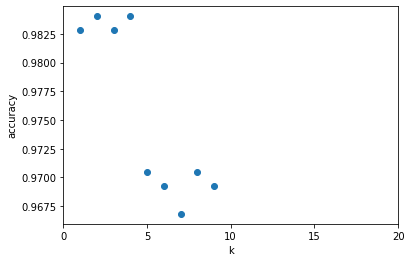

In [94]:
k_range = range(1, 10)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])